## Experiment for mean non-convergence problem with Gaussian target

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import torch
import math
import torch.distributions as dists
from scem import loss, util, kernel, net, stein, cpdkernel
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from os.path import dirname, join
import pickle
import ksdmom.sampler as samp
from collections import namedtuple

In [22]:
results_path = './results/meanshift'
problem = 'Gaussian'

In [23]:
torch.manual_seed(101)
torch.set_default_tensor_type(torch.DoubleTensor)

In [24]:
font = {
    'family' : 'serif',
#     'weight' : 'bold',
    'size'   : 24
}
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.usetex'] = True
plt.rc('font', **font)
plt.rc('lines', linewidth=3, markersize=10)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


In [25]:
dir_path = (join(results_path, problem))
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

In [33]:
class Normal:
    def __init__(self, m, s):
        self.m = m 
        self.s = s
    
    def den(self, X):
        m = self.m
        s = self.s 
        
        den = torch.exp(-torch.sum((X-m)**2, axis=1)/(2*s**2))
        den /= (2*math.pi*s**2)**(d/2)
        return den
    
    def log_den(self, X):
        m = self.m
        s = self.s
        ld = -torch.sum((X-m)**2, axis=1)/(2*s**2)
        ld -= d/2 * torch.log(torch.tensor(2*math.pi*s**2))
        return ld
    
    def score(self, X):
        m = self.m 
        s = self.s
        return -(X-m) / s**2
    
    def sample(self, n):
        m = self.m
        d = len(m)
        return m + self.s * torch.randn(n, d)
    
class MixNormal:
    def __init__(self, m1, m2, s1, s2, mweights=None):
        self.m1 = m1
        self.m2 = m2
        self.s1 = s1
        self.s2 = s2
        self.mweights = (mweights if mweights is not None else 
                         torch.ones(2)/2.)
    
    def score(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        mweights = self.mweights

        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)

        score1 = -(X - m1)/(s1**2) 
        score2 = -(X - m2)/(s2**2) 
        
        post_prob1 = mweights[0] * den1 / (mweights[0]*den1 + mweights[1]*den2)
        post_prob1 = post_prob1.unsqueeze(1)
        post_prob2 = 1. - post_prob1
        sc = post_prob1*score1 + post_prob2*score2
        return sc
    
    def den(self, X):
        m1 = self.m1
        m2 = self.m2
        s1 = self.s1
        s2 = self.s2
        d = len(self.m1)
        w = self.mweights
        den1 = torch.exp(-torch.sum((X-m1)**2, axis=1)/(2*s1**2))
        den1 /= (2*math.pi*s1**2)**(d/2)
        den2 = torch.exp(-torch.sum((X-m2)**2, axis=1)/(2*s2**2))
        den2 /= (2*math.pi*s2**2)**(d/2)
        return w[0]*den1 + w[1]*den2
    
    def log_den(self, X):
        return torch.log(self.den(X))
    
    def sample(self, n):
        m = torch.distributions.Binomial(n, torch.tensor([self.mweights[0]]))        
        n1 = int(m.sample().item())
        n2 = n - n1 
        print(n2)
        d = len(self.m1)
        X1 = self.s1*torch.randn(n1, d) + self.m1
        X2 = self.s2*torch.randn(n2, d) + self.m2
        X = torch.cat([X1, X2])
        for _ in range(30):
            idx = torch.randperm(n)
            X = X[idx]
        return X

In [34]:
n = 1000
rep = 1
n_ps = 100
d = 5
m = -torch.ones(d)/d**0.5
s = 1
target = Normal(m, s)
rerun = False
vstat = True

### Defining kernels

In [35]:

kimq  = kernel.KIMQ(b=-0.5)
loc = None
klin = kernel.KLinear(scale=1, loc=loc, bias=1)
w = kernel.MultiquadraticWeight(p=-0.5, bias=1, loc=loc)
kw = kernel.KSTWeight(w_func=w)
ktilted_lin = kernel.KSTProduct(klin, kw)
ksum_imq = kernel.KSTSumKernel([ktilted_lin, kimq])

w_ = kernel.MultiquadraticWeight(p=0.1/2, bias=1, loc=loc)
kw_ = kernel.KSTWeight(w_func=w_)
kx = kernel.KSTProduct(ksum_imq, kw_)

kmat = kernel.KMatern(scale=1)
kmat_sum = kernel.KSTSumKernel([ktilted_lin, kimq])
kmat_sum = kernel.KSTProduct(kmat_sum, kw_)

kernels = {
    'IMQ': kimq, 
    # 'IMQ-sum-theta': kx,
    'IMQ-sum': ksum_imq,
#     'Mat-sum': kmat_sum,
}

### Perturbing the target distribution

In [36]:
ptbs = torch.logspace(0, 8, n_ps)
data = np.empty([len(kernels), rep, n_ps])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
sampler = samp.MixSampler(target, Normal(m, s))
bias = torch.ones(d) / d**0.5
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}.npy'.format(key) if not vstat else
        '{}_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp
    else:
        for j, p in enumerate(ptbs):
            prob = torch.ones(1) / (p+1)
            X1 = target.sample(n//2)
            mean = bias / prob
            X2 = s**0.5 * torch.randn(n//2, d) + mean 
            weight = torch.ones(n)
            weight[:n//2] = torch.ones(1) - prob
            weight[n//2:] = prob
            X = torch.vstack([X1, X2])
            for i in range(rep):
                data[l_i, i, j] = l.loss(X, vstat=vstat, weight=weight, ignore_diag=False).detach().numpy()
        result = data[l_i]
        np.save(path, result)  
ps = ptbs.detach().numpy()

In [45]:
Format = namedtuple('Format', ['color', 'linestyle', 'marker'])
label_format_tuples = {
    'IMQ': ("IMQ ", Format('C1', '-', '*')),
    'IMQ-sum': ('IMQ sum (lin.)', Format('C2', '--', 'o')),
    # 'IMQ-sum-theta': ('IMQ sum (lin.) $\\theta=0.1$', Format('C3', '-.', 'v')),
}

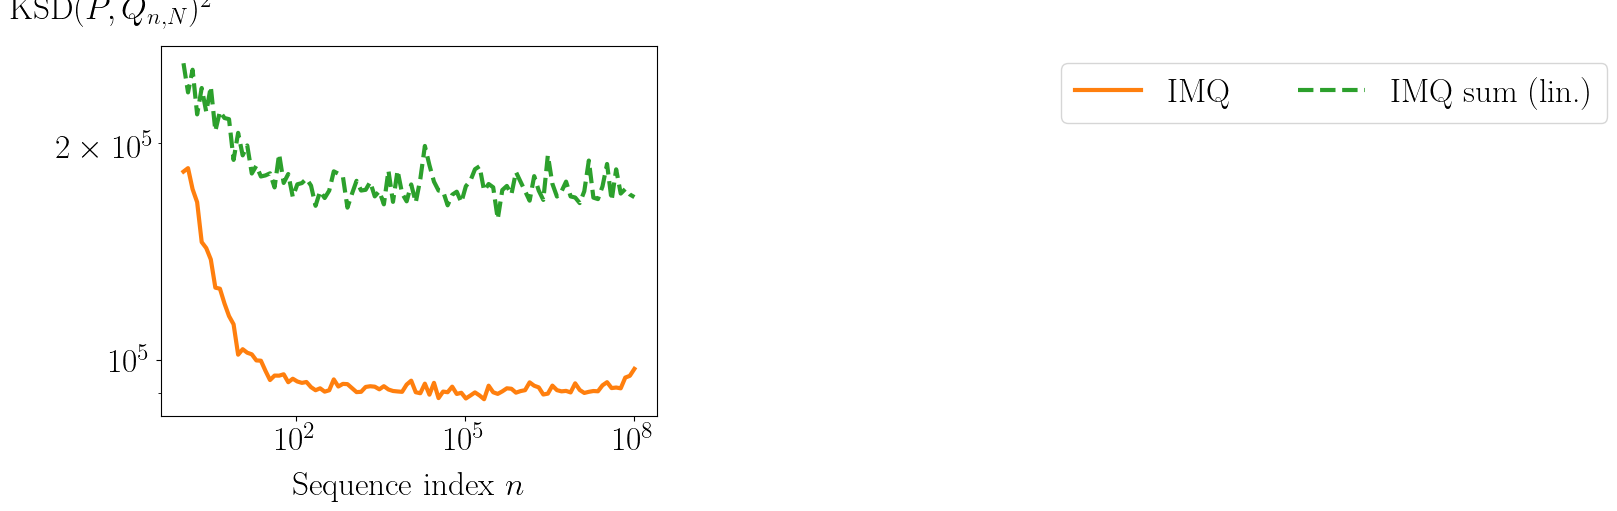

In [48]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sequence index $n$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{KSD}(P, Q_{n,N})^2$', fontsize = 24)
label.set_rotation(0)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.1, 1.05)    

ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = ptbs.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
#     y = data[ki][0]
    ax.plot(ps, y, label=label, 
        color=fmt.color, linestyle=fmt.linestyle)

#     error_low = (y - np.percentile(data[ki], q=5, axis=0))
#     error_high = np.percentile(data[ki], q=95, axis=0)-y
#     errors = np.vstack([error_low, error_high])
#     ax.errorbar(ps, y, yerr=errors,
#             color=fmt.color, label=label, linestyle=fmt.linestyle)
#     ax.violinplot(data[ki], ps, showmeans=True, showextrema=False, widths=1.5)

ax.legend(bbox_to_anchor=(2.95,1.), ncol=4)
# plt.legend(bbox_to_anchor=(1.75,1.), ncol=2)
ax.set_yscale('log')
ax.set_xscale('log')

#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
 
# plt.savefig('ksd_comparison_mean_shift.pdf', bbox_inches='tight')
# plt.savefig('ksd_comparison_mean_shift_vstat.pdf', bbox_inches='tight')
# plt.savefig('ksd_comparison_mean_shift_legend_col2.pdf', bbox_inches='tight')
plt.savefig('ksd_comparison_mean_shift_legend.pdf', bbox_inches='tight')

### Varying sample size 

In [18]:
rerun = False
n_ps_sample = 30
sample_sizes = torch.logspace(2, 4, n_ps_sample)
sample_sizes = torch.floor(sample_sizes/2)
data = np.empty([len(kernels), rep, n_ps_sample])
losses = {
    k: loss.KSD(v, target.score) 
    for k, v in kernels.items()
}
p = 1e+6
prob = torch.ones(1) / p 
mean = p * bias
for l_i, (key, l) in enumerate(losses.items()):
    filename = (
        '{}._sampinc_npy'.format(key) if not vstat else
        '{}_sampinc_vstat.npy'.format(key)
    )
    path = os.path.join(dir_path, filename)
    if os.path.exists(path) and not rerun:
        tmp = np.load(path)
        data[l_i] = tmp[:rep]
    else:
        for j, n in enumerate(sample_sizes):
            n = int(n.item())
            X1 = target.sample(n)
            X2 = s**0.5 * torch.randn(n, d) + mean 
            weight = torch.ones(2*n)
            weight[:n] = torch.ones(1) - prob
            weight[n:] = prob
            X = torch.vstack([X1, X2])
            for i in range(rep):
                data[l_i, i, j] = l.loss(X, vstat=vstat, weight=weight, ignore_diag=False).detach().numpy()
        result = data[l_i]
        np.save(path, result)               

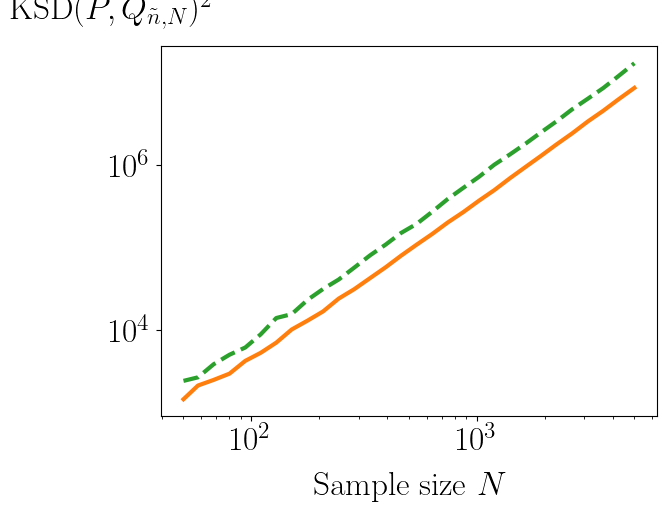

In [19]:
from matplotlib.ticker import LogLocator
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')


label = ax.set_xlabel('Sample size $N$', fontsize = 24)
label = ax.set_ylabel('$\\mathrm{KSD}(P, Q_{\\tilde{n}, N})^2$', fontsize = 24)
label.set_rotation(0)
ax.xaxis.set_label_coords(0.5, -0.15)
ax.yaxis.set_label_coords(-0.1, 1.05)    

ax.set_yticks([1e+0, 1e+1, 1e+2])

ps = sample_sizes.detach().numpy()
for ki, key in enumerate(losses.keys()):
    label = label_format_tuples[key][0]
    fmt = label_format_tuples[key][1]
    y = data[ki].mean(axis=0)
    ax.plot(ps, y, label=label, 
        color=fmt.color, linestyle=fmt.linestyle)

#     error_low = (y - np.percentile(data[ki], q=5, axis=0))
#     error_high = np.percentile(data[ki], q=95, axis=0)-y
#     errors = np.vstack([error_low, error_high])
#     ax.errorbar(ps, y, yerr=errors,
#             color=fmt.color, label=label, linestyle=fmt.linestyle)
#     ax.violinplot(data[ki], ps, showmeans=True, showextrema=False, widths=1.5)

# ax.legend(bbox_to_anchor=(1.75,1.), ncol=4)
# plt.legend(bbox_to_anchor=(1.75,1.), ncol=2)
ax.set_yscale('log')
ax.set_xscale('log')

#ax.yaxis.set_minor_locator(LogLocator(numticks=10))
plt.savefig('ksd_comparison_mean_shift_sampsize_vstat.pdf', bbox_inches='tight')